In [1]:
import pandas as pd
import os
import random
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import BertTokenizer
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import BCELoss

from common_stuff import ConvNeXt, EfficientNet, MultiSolver, PictureDataset, TextDataset
from common_stuff import transform
from common_stuff import device

from sklearn.model_selection import train_test_split

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

df = pd.read_csv("../../post2ctr_dataset.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

train_dataset = PictureDataset(train_df, transform=transform)
test_dataset = PictureDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [3]:
effnet_paths = [
    "../../effnet_MSE.pth", "../../effnet_BCE.pth", "../../effnet_BCEWeighted_2.pth", "../../effnet_BCEWeighted_3.pth", "../../effnet_BCEWeighted_4.pth",
]
convnext_paths = [
    "../../convnext_MSE.pth", "../../convnext_BCE.pth", "../../convnext_BCEWeighted_2.pth", "../../convnext_BCEWeighted_3.pth", "../../convnext_BCEWeighted_4.pth",
]
model_paths = [effnet_paths, convnext_paths]

def load_convnext_model(model_path):
    model = ConvNeXt()
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def load_effnet_model(model_path):
    model = EfficientNet()
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def evaluate_model(model, name, loader):
    predictions, targets = [], []
    model.eval()
    with torch.no_grad():
        for data in loader:
            inputs = data["img"].to(device)
            target = data["target"].to(device, dtype=torch.float)
            outputs = model(inputs)

            predictions.append(outputs)
            targets.append(target)
    
    targets = torch.cat(targets, dim=0).squeeze().cpu()
    predictions = torch.cat(predictions, dim=0).squeeze().cpu()
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    logloss = BCELoss()(np.clip(targets, 1e-15, 1-1e-15), np.clip(predictions, 1e-15, 1-1e-15))
    
    return mse, mae, logloss.item(), predictions, targets

Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


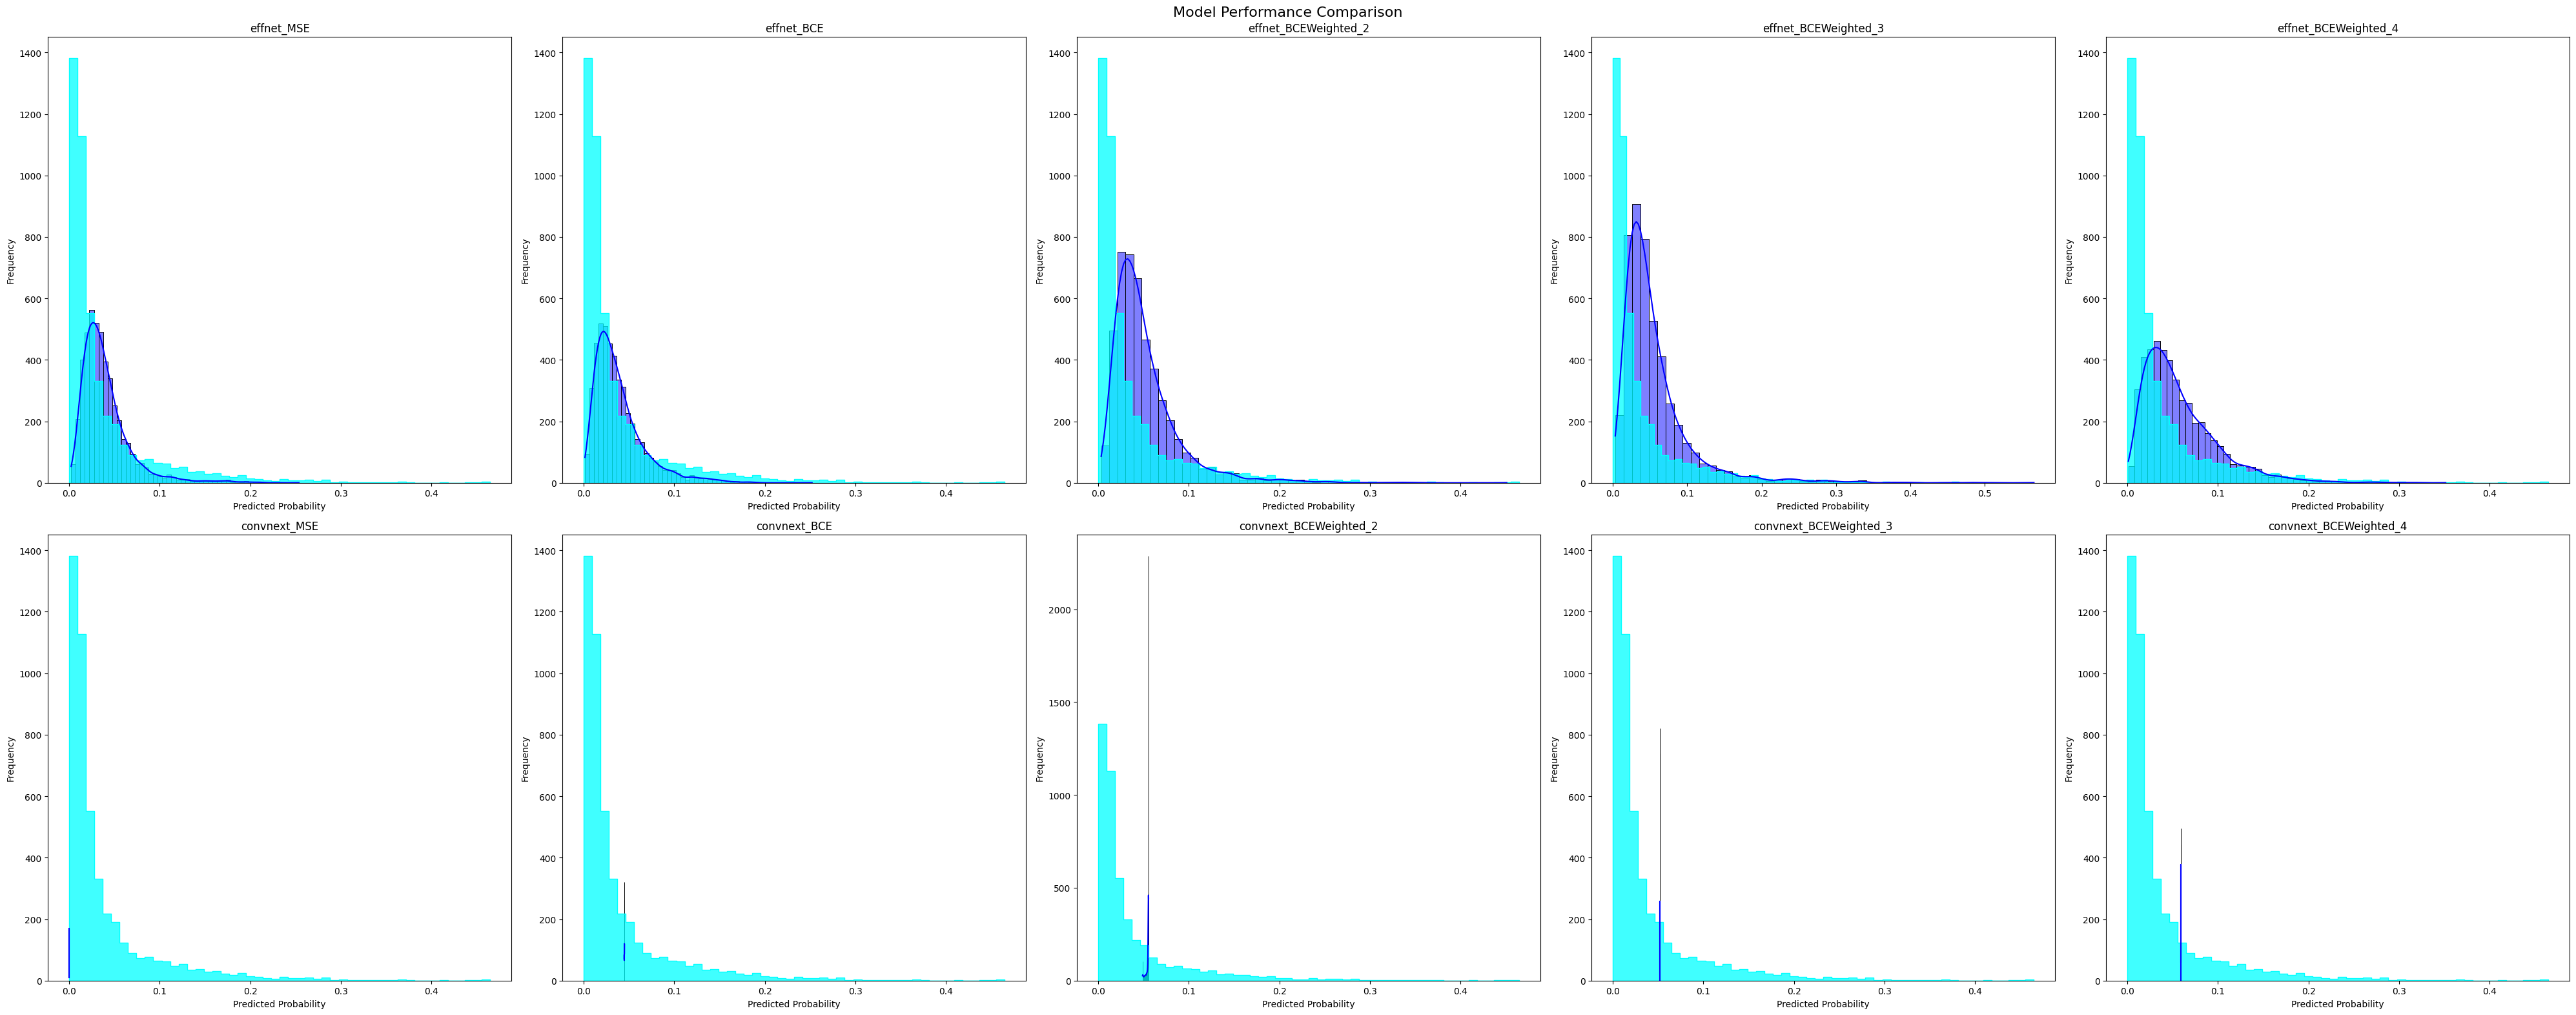

                    Model       MSE       MAE   Logloss
0              effnet_MSE  0.002891  0.034337  0.214413
1              effnet_BCE  0.002915  0.033842  0.207985
2    effnet_BCEWeighted_2  0.003655  0.041251  0.269062
3    effnet_BCEWeighted_3  0.004688  0.044602  0.293175
4    effnet_BCEWeighted_4  0.004088  0.045251  0.295959
5            convnext_MSE  0.004318  0.037764  0.040280
6            convnext_BCE  0.002942  0.038742  0.251473
7  convnext_BCEWeighted_2  0.003167  0.044094  0.296076
8  convnext_BCEWeighted_3  0.003098  0.042762  0.285593
9  convnext_BCEWeighted_4  0.003340  0.046920  0.317592


In [4]:
fig, axes = plt.subplots(2, 5, figsize=(40, 16))
fig.suptitle("Model Performance Comparison", fontsize=16)
metrics_results = []

for i, model_paths_group in enumerate(model_paths):
    for j, model_path in enumerate(model_paths_group):
        model = None
        if i == 0:
            model = load_effnet_model(model_path)
        else:
            model = load_convnext_model(model_path)
        model = model.to(device)
        name = model_path[6:-4]
        mse, mae, logloss, preds, targets = evaluate_model(model, name, test_loader)

        sns.histplot(preds, bins=50, color="blue", kde=True, label="Predictions", ax=axes[i, j])
        sns.histplot(targets, bins=50, color="cyan", kde=False, label="Actual", ax=axes[i, j], element="step")
        
        axes[i, j].set_title(f"{name}")
        axes[i, j].set_xlabel("Predicted Probability")
        axes[i, j].set_ylabel("Frequency")

        metrics_results.append({
            "Model": name,
            "MSE": mse,
            "MAE": mae,
            "Logloss": logloss
        })

metrics_df = pd.DataFrame(metrics_results)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print(metrics_df)

Using cache found in /home/vivy/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imsho

tensor([0.0173, 0.0740, 0.0394, 0.0302, 0.0309, 0.1623, 0.0141, 0.1841])
tensor([0.0125, 0.0090, 0.0113, 0.0574, 0.0379, 0.0187, 0.0095, 0.2159])


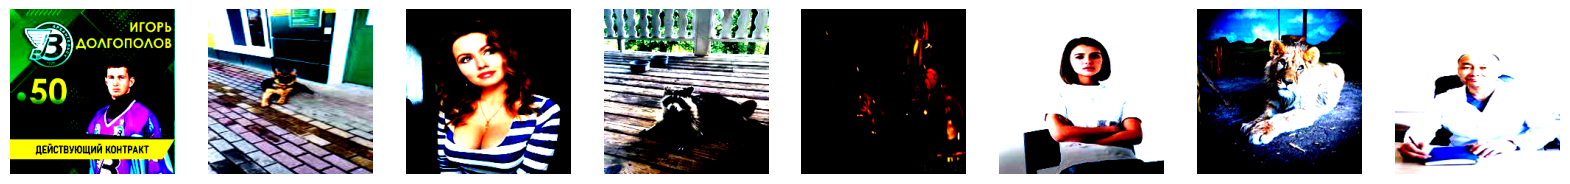

In [5]:
model = EfficientNet()
model.load_state_dict(torch.load("../../effnet_BCEWeighted_3.pth", weights_only=True))
model.eval()

test_dataset = PictureDataset(test_df, transform=A.Compose([A.Resize(224, 224), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2(transpose_mask=True)]))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader, 0):
        if batch_idx != 3:
            continue
        images = data["img"].to(dtype=torch.float)
        targets = data["target"].to(dtype=torch.float).squeeze()            
        outputs = model(images).squeeze()
        images = images.permute(0, 2, 3, 1).cpu().numpy()
        fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
        print(outputs)
        print(targets)

        for i, img in enumerate(images):
            axs[i].imshow(img)
            axs[i].axis('off')

        plt.show()
        break

In [6]:
def split_post(cell):
    return str(cell["text"]).split()

df = pd.read_csv("../../post2ctr_dataset.csv")
df["splitted"] = df.apply(split_post, axis=1)

max_size = 224

transform = transforms.Compose([
    transforms.Resize((max_size, max_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

train_dataset = TextDataset(train_df, tokenizer=tokenizer, transform=transform)
test_dataset = TextDataset(test_df, tokenizer=tokenizer, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/home/vivy/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5699118..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping in

tensor([0.0045, 0.0439, 0.1447, 0.0139, 0.0302, 0.0256, 0.2199, 0.0967],
       device='cuda:0')
tensor([0.0024, 0.0370, 0.0140, 0.0291, 0.0067, 0.0077, 0.0697, 0.1364],
       device='cuda:0')


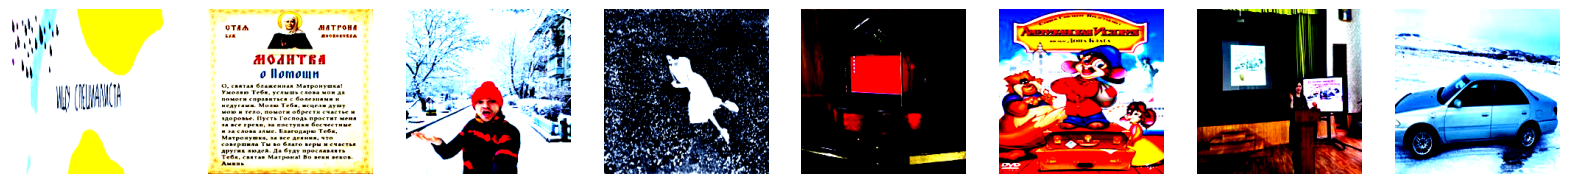

In [7]:
model = MultiSolver(768, 768)
model.load_state_dict(torch.load("../../convnext_bert_recsys.pth", weights_only=True))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader, 0):
        if batch_idx != 9:
            continue
        images = data["img"].to(device)
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_ids = data["token_type_ids"].to(device, dtype=torch.long)
        targets = data["target"].to(device, dtype=torch.float).squeeze()
        outputs = model(ids, mask, token_ids, images).squeeze()

        images = images.permute(0, 2, 3, 1).cpu().numpy()
        fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
        print(outputs)
        print(targets)

        for i, img in enumerate(images):
            axs[i].imshow(img)
            axs[i].axis('off')
        break

MSE : 0.0031     MAE : 0.0344     Logloss : 0.2031


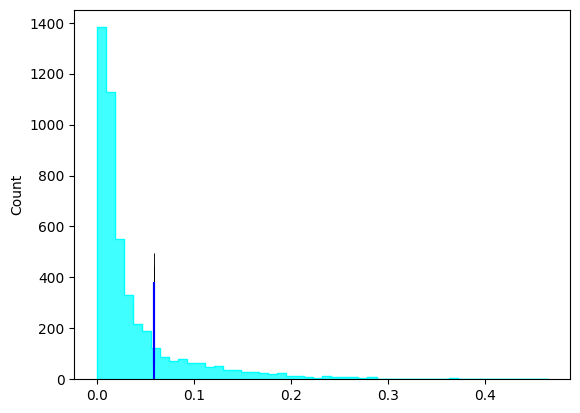

In [9]:
predictions, targets = [], []
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader, 0):
        images = data["img"].to(device)
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_ids = data["token_type_ids"].to(device, dtype=torch.long)
        targets.append(data["target"].to(device, dtype=torch.float))
        predictions.append(model(ids, mask, token_ids, images))
targets = torch.cat(targets, dim=0).squeeze().cpu()
predictions = torch.cat(predictions, dim=0).squeeze().cpu()
mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)
logloss = BCELoss()(np.clip(targets, 1e-15, 1-1e-15), np.clip(predictions, 1e-15, 1-1e-15))
print(f"MSE : {mse:.4f}     MAE : {mae:.4f}     Logloss : {logloss:.4f}")
sns.histplot(preds, bins=50, color="blue", kde=True, label="Predictions")
sns.histplot(targets, bins=50, color="cyan", kde=False, label="Actual", element="step")
plt.show()